<a href="https://www.kaggle.com/code/joshuacurtiswebb/simuledge?scriptVersionId=138595468" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import logging
import sys
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, time
import matplotlib.pyplot as plt
from time import perf_counter
from spx_strategies import *
import optuna
import os
from shutil import copy
from textwrap import wrap
pd.set_option("max_columns", 200)

#copy db
cwd = os.getcwd()
output_spx_spread_backtester_path = '/kaggle/input/spx-option-spread-backtester/'
dir_list = os.listdir(output_spx_spread_backtester_path)
files = [f for f in dir_list if os.path.isfile(output_spx_spread_backtester_path+f) and ".db" in f] #Filtering only the db files.
for f in files:
    if not os.path.exists(cwd+'/'+f):
        print(f"Copying db file to output : {f}")
        copy(output_spx_spread_backtester_path+f,cwd+'/'+f)



#########################
# Settings for backtest #
#########################
purchase_time = '15:45:00'
# In dollars
commission = 1.5



files = [
#     f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2020_0dte_all.csv", 
#     f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2021_0dte_all.csv", 
#    f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2022_0dte_all.csv"
    #f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2021_1545_1600.csv",
   # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2020_1545_1600.csv"
   # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2022_1545_1600.csv"
 #  f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2019_1545_1600.csv"
  #  f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2018_1545_1600.csv"
   # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2017_1545_1600.csv"
  # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2016_1545_1600.csv"
  # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2019_1dte_all.csv",
    f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2020_1dte_all.csv",
   # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2021_1dte_all.csv",
   # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2022_1dte_all.csv"
]
li = []
for f in files:   
    df = pd.read_csv(f, index_col=None, header=0, dtype={'type':'category','quote_time':'category'})
    li.append(df)
    
df = pd.concat(li, axis=0, ignore_index=True)
df['expiration']=pd.to_datetime(df['expiration'],infer_datetime_format=True)
df['quote_date']=pd.to_datetime(df['quote_date'],infer_datetime_format=True)
df['delta'] = df['delta'].abs()

if 'dte' not in df:
    raise Exception("dte must be present")

initial_portfolio_value = df.loc[1,'price']*20

df_ty = pd.read_csv(f"/kaggle/input/treasury-yield-13w-2012-2022/13_week_treasury_yield.csv", index_col=None, header=0)
df_ty['Date'] = pd.to_datetime(df_ty['Date'])

Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-07-31-20.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-07-31-23.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-07-29-23.db
Copying db file to output : optimal-short-straddle-study_2021-2022_1DTE_1.db
Copying db file to output : optimal-iron-condor-study_2022_1.db
Copying db file to output : optimal-iron-condor-study.db
Copying db file to output : optimal-short-straddle-study_2019-2022_1DTE_1.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-07-30-23.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-07-28-23.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-07-27-23.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-07-27-19.db


In [2]:
for dirname, _, filenames in os.walk('/kaggle/input/spx-option-chain-1dte-all-times'):
    for f in filenames:
        if 'spx' in f:
            df = pd.read_csv(os.path.join(dirname, f), index_col=None, header=0)
            df.rename(columns={'underlying':'price'},inplace=True)
            df.drop(columns=['Unnamed: 0'], inplace=True)
            df['expiration']=pd.to_datetime(df['expiration'],infer_datetime_format=True)
            df['quote_date']=pd.to_datetime(df['quote_date'],infer_datetime_format=True)
            df['delta'] = df['delta'].abs()
            initial_portfolio_value = df.loc[1,'price']*20
        elif 'irx' in f:
            df_irx = pd.read_csv(os.path.join(dirname, f), index_col=None, header=0)
            df_irx.rename(columns={'close':'Adj Close','quote_date':'Date'},inplace=True)
            df_irx['Adj Close']*= 100
            df_irx['Date']=pd.to_datetime(df_irx['Date'],infer_datetime_format=True)
            df_irx['quote_time']=pd.to_datetime(df_irx['quote_time'],infer_datetime_format=True)
            df_irx = df_irx.loc[df_irx.groupby('Date')['quote_time'].idxmax()]
            df_irx.drop(columns=['Unnamed: 0', 'quote_time'], inplace=True)



# Backtest Optimization

In [3]:
# dos = DeltaOptionSelector(short_puts=0.15,short_calls=0.18)
# # dos = YieldOptionSelector(short_puts=0.001, short_calls=[0.0003], ipv=initial_portfolio_value)
# ent_pol=OptionSelectorStaticEntryPolicy(1, purchase_time, dos)
# ex_pol = HoldToExpStaticExitPolicy('16:00:00')
# # # ex_pol = MaxLossDynamicExitPolicy(commission, 1.5)
# strat = StaticEntryStaticExitStrategy(commission, df_irx, initial_portfolio_value, ent_pol, ex_pol, debug=True)
# strat.evaluate(df)


In [4]:
def run_backtest(strat, df):
    return strat.evaluate(df)

In [5]:
def objective(trial, df, purchase_time):
    delta_sp_trial = trial.suggest_float("delta_sp", 0.002, 0.45)
#     delta_lp_trial = trial.suggest_float("delta_p_offset", 0.001, 0.5)
    delta_sc_trial = trial.suggest_float("delta_sc", 0.002, 0.45)
#     delta_lc_trial = trial.suggest_float("delta_c_offset", 0.001, 0.50)
#     max_loss = trial.suggest_float("max_loss", 1.25, 4.0)
   
    dos = DeltaOptionSelector(short_puts=delta_sp_trial,short_calls=delta_sc_trial)
    ent_pol=OptionSelectorStaticEntryPolicy(1, purchase_time, dos)
    ex_pol = HoldToExpStaticExitPolicy('16:00:00')

    strategy = StaticEntryStaticExitStrategy(commission, df_irx, initial_portfolio_value, ent_pol, ex_pol, debug=False)
    score = run_backtest(strategy, df)
    return score

In [6]:
study_name = f"optimal-short-straddle-study_2023-2023_1DTE_{datetime.today().strftime('%Y-%m-%d-%H')}"  # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(direction = "maximize", study_name=study_name, storage=storage_name, load_if_exists=True)
study.optimize(lambda trial: objective(trial, df, purchase_time), n_trials = 100)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

[I 2023-08-01 15:17:26,723] A new study created in RDB with name: optimal-short-straddle-study_2023-2023_1DTE_2023-08-01-15
[I 2023-08-01 15:17:29,482] Trial 0 finished with value: 25.948 and parameters: {'delta_sp': 0.2195129002278523, 'delta_sc': 0.442824710338024}. Best is trial 0 with value: 25.948.
[I 2023-08-01 15:17:32,187] Trial 1 finished with value: 28.913 and parameters: {'delta_sp': 0.24253231935873135, 'delta_sc': 0.41318557360681113}. Best is trial 1 with value: 28.913.
[I 2023-08-01 15:17:34,756] Trial 2 finished with value: 87.376 and parameters: {'delta_sp': 0.14735050274912992, 'delta_sc': 0.006661224839683413}. Best is trial 2 with value: 87.376.
[I 2023-08-01 15:17:37,352] Trial 3 finished with value: 37.587 and parameters: {'delta_sp': 0.30933213775853163, 'delta_sc': 0.0066416311844970655}. Best is trial 2 with value: 87.376.
[I 2023-08-01 15:17:39,971] Trial 4 finished with value: 63.631 and parameters: {'delta_sp': 0.33061686240091204, 'delta_sc': 0.179757015399

Best Score:  128.725
Best Params: 
  delta_sc: 0.13203186584758653
  delta_sp: 0.141388895286396


# Backtest with current best score

*****  BACKTEST RESULTS  ****

Cumulative return:                      4.352 % 
Max Drawdown:                            0.34 % 
Trading Days:                              11 
Wins:                                      11 
Losses:                                     0 
Breakeven:                                  0 
Win/Loss Ratio:                         100.0 % 
Mean Win:                             356.864 $ 
Mean Win Trans Return:                  0.393 % 
Mean Loss:                                nan $ 
Mean Loss Trans Return:                   nan % 
Mean Net Trans:                       356.864 $ 
Mean Trans Return:                      0.393 % 
Std Dev of Net Trans:                 103.139 
Std Dev of Trans Return:                0.001 
Max Loss:                               267.0 $ 
Max Win:                                584.5 $ 
Sharpe Ratio static STD:               51.667 
Sharpe Ratio with RF STD:               51.68 
Risk Adj Cumulative Return:          3807.499 
Dampene

128.725

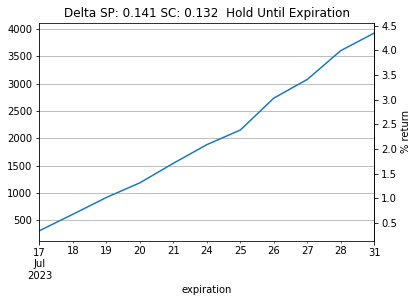

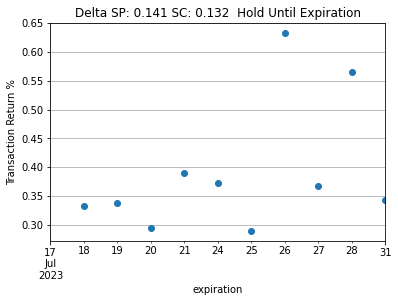

In [7]:
dos = DeltaOptionSelector(short_puts=trial.params['delta_sp'],short_calls=trial.params['delta_sc'])
ent_pol=OptionSelectorStaticEntryPolicy(1, purchase_time, dos)
ex_pol = HoldToExpStaticExitPolicy('16:00:00')
strat = StaticEntryStaticExitStrategy(commission, df_irx, initial_portfolio_value, ent_pol, ex_pol, debug=True)
strat.evaluate(df)

# Strikes for tomorrow with current best

In [8]:
next_exp = df['expiration'].max()
quote_date_next_exp = df[(df['expiration']==df['expiration'].max())&(df['quote_date']!=df['expiration'].max())]['quote_date'].iloc[0]
df_trades = pd.DataFrame([{'trade_date':quote_date_next_exp,'expiration':next_exp}])
df_filt = df[
    (df['expiration']==df['expiration'].max())&
    (df['quote_date']!=df['expiration'].max())&
    (df['quote_time']=='16:00:00')
]

In [9]:
dos = DeltaOptionSelector(short_puts=trial.params['delta_sp'],short_calls=trial.params['delta_sc'])
ent_pol=OptionSelectorStaticEntryPolicy(1, '16:01:00', dos)
dos.populateTrades(df_filt,df_trades,ent_pol.get_contract_strike)

,trade_date,expiration,delta_sp_target_0,strike_sp_0,delta_sp_0,collected_sp_0,delta_sc_target_0,strike_sc_0,delta_sc_0,collected_sc_0,trade_count,collected
0,2023-07-31,2023-08-01,0.141389,4555.0,0.138245,150.0,0.132032,4615.0,0.12061,185.0,2,335.0


# Strikes following the 4/2 Strategy

In [10]:
dos = DeltaOptionSelector(short_puts=0.04,short_calls=0.02)
ent_pol=OptionSelectorStaticEntryPolicy(1, '16:01:00', dos)
dos.populateTrades(df_filt,df_trades,ent_pol.get_contract_strike)

,trade_date,expiration,delta_sp_target_0,strike_sp_0,delta_sp_0,collected_sp_0,delta_sc_target_0,strike_sc_0,delta_sc_0,collected_sc_0,trade_count,collected
0,2023-07-31,2023-08-01,0.04,4525.0,0.033843,40.0,0.02,4640.0,0.019339,20.0,2,60.0
